In [2]:
#import SparkSession
from pyspark.sql import SparkSession
#create spark object
spark=SparkSession.builder.appName('total_time').getOrCreate()

In [3]:
#reading a file
df=spark.read.csv('br_word_emb_data.csv',header=True,inferSchema=True)

In [4]:
df.printSchema()

root
 |-- visitor_id: string (nullable = true)
 |-- date_time_ts: timestamp (nullable = true)
 |-- session_id: integer (nullable = true)
 |-- page_category: string (nullable = true)
 |-- time_spent_in_mins: double (nullable = true)
 |-- is_converted: integer (nullable = true)



In [5]:
df.show(10,False)

+---------------------------------------+-------------------+----------+--------------+------------------+------------+
|visitor_id                             |date_time_ts       |session_id|page_category |time_spent_in_mins|is_converted|
+---------------------------------------+-------------------+----------+--------------+------------------+------------+
|1014693057261549843_9055106623262667991|2017-05-24 22:00:41|0         |homepage      |0.16666667        |1           |
|1014693057261549843_9055106623262667991|2017-05-24 22:00:51|0         |vehiclenew    |0.4               |1           |
|1014693057261549843_9055106623262667991|2017-05-24 22:01:15|0         |specifications|0.31666666        |1           |
|1014693057261549843_9055106623262667991|2017-05-24 22:02:42|0         |accessories   |0.6333333         |1           |
|1014693057261549843_9055106623262667991|2017-05-24 22:03:20|0         |specifications|0.15              |1           |
|1014693057261549843_9055106623262667991

In [6]:
df = df.filter("page_category != ''")

In [7]:
df.select('page_category').distinct().count()

25

In [7]:
df.groupBy('page_category').count().orderBy('count',ascending=False).show(50,False)

+---------------------+------+
|page_category        |count |
+---------------------+------+
|vehiclenew           |543405|
|homepage             |137195|
|specifications       |86565 |
|dealerfinder         |43385 |
|offers               |32003 |
|performance          |29409 |
|design               |27560 |
|periodicreview       |23443 |
|characteristics      |22820 |
|directselling        |17518 |
|testdrive            |17317 |
|accessories          |16334 |
|pcd                  |16192 |
|selectvehicle        |16190 |
|features             |13361 |
|experience           |10075 |
|services             |9593  |
|testdriveconfirmation|7599  |
|selectdealer         |7512  |
|manuals              |5846  |
|contactus            |5261  |
|error                |3058  |
|others               |3053  |
|warranty             |2163  |
|social               |98    |
+---------------------+------+



In [9]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def page_udf(page):
    if page =='error':
        return 'others'
    elif page =='social':
        return 'others'
    elif page =='dealerfinder':
        return 'others'
    elif page =='testdrive':
        return 'others'
    elif page =='testdriveconfirmation':
        return 'others'
    elif page =='selectdealer':
        return 'others'
    else:
        return page
        
nissan_udf = udf(page_udf, StringType())

df_updated=df.withColumn("page_new", nissan_udf(df.page_category))

In [10]:
df_updated.select('page_new').distinct().count()

19

In [11]:
df_updated.groupBy('page_new').count().orderBy('count',ascending=False).show(50,False)

+---------------+------+
|page_new       |count |
+---------------+------+
|vehiclenew     |543405|
|homepage       |137195|
|specifications |86565 |
|others         |82022 |
|offers         |32003 |
|performance    |29409 |
|design         |27560 |
|periodicreview |23443 |
|characteristics|22820 |
|directselling  |17518 |
|accessories    |16334 |
|pcd            |16192 |
|selectvehicle  |16190 |
|features       |13361 |
|experience     |10075 |
|services       |9593  |
|manuals        |5846  |
|contactus      |5261  |
|warranty       |2163  |
+---------------+------+



In [12]:
from pyspark.ml.feature import StringIndexer
import sys
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.sql.functions import  lag


In [13]:
#not considering session
w = Window.partitionBy("visitor_id").orderBy('date_time_ts')

In [14]:
#replacing null values with drop

new_df=df_updated.withColumn("next_page", lag("page_new", 1, 'started').over(w))

In [15]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import math

def indicator(old_page, new_page):
    if old_page == new_page:
        return 0
    else:
        return 1
    

ind_udf = udf(indicator,IntegerType())
new_df=new_df.withColumn("Indicator",ind_udf(new_df.page_new,new_df.next_page))

In [16]:

from pyspark.sql.functions import sum

In [17]:
df_cumsum = new_df.withColumn('indi_cummulative',sum(new_df.Indicator).over(w))
df_cumsum.select(['visitor_id','date_time_ts','Indicator','indi_cummulative']).show(30,False)

+---------------------------------------+-------------------+---------+----------------+
|visitor_id                             |date_time_ts       |Indicator|indi_cummulative|
+---------------------------------------+-------------------+---------+----------------+
|1000739068748979102_8438638593588432327|2018-02-24 17:15:07|1        |1               |
|1000739068748979102_8438638593588432327|2018-02-24 17:15:29|1        |2               |
|1000739068748979102_8438638593588432327|2018-02-24 17:15:40|1        |3               |
|1000739068748979102_8438638593588432327|2018-02-24 17:16:04|1        |4               |
|1000739068748979102_8438638593588432327|2018-02-24 17:16:50|1        |5               |
|1000739068748979102_8438638593588432327|2018-02-24 17:17:19|1        |6               |
|1000739068748979102_8438638593588432327|2018-02-24 17:17:47|1        |7               |
|1000739068748979102_8438638593588432327|2018-02-24 17:17:56|1        |8               |
|1000739068748979102_

In [18]:
w2 = Window.partitionBy(["visitor_id",'indi_cummulative']).orderBy('date_time_ts')

In [19]:
df_final = df_cumsum.withColumn('time_cumm',sum(df_cumsum.time_spent_in_mins).over(w2))
df_final.select(['visitor_id','date_time_ts','page_new','next_page','time_cumm','time_spent_in_mins','Indicator','indi_cummulative']).show(30,False)

+---------------------------------------+-------------------+--------------+--------------+-----------+------------------+---------+----------------+
|visitor_id                             |date_time_ts       |page_new      |next_page     |time_cumm  |time_spent_in_mins|Indicator|indi_cummulative|
+---------------------------------------+-------------------+--------------+--------------+-----------+------------------+---------+----------------+
|1000739068748979102_8438638593588432327|2018-02-24 17:15:07|homepage      |started       |0.36666667 |0.36666667        |1        |1               |
|1000739068748979102_8438638593588432327|2018-02-24 17:15:29|vehiclenew    |homepage      |0.18333334 |0.18333334        |1        |2               |
|1000739068748979102_8438638593588432327|2018-02-24 17:15:40|specifications|vehiclenew    |0.06666667 |0.06666667        |1        |3               |
|1000739068748979102_8438638593588432327|2018-02-24 17:16:04|accessories   |specifications|0.4833333

In [20]:
w5 = Window.partitionBy(["visitor_id",'indi_cummulative']).orderBy(col('date_time_ts').desc())

In [21]:
df_final_new= df_final.withColumn('final_category',first('page_new').over(w5))\
                        .withColumn('final_time_spent',first('time_cumm').over(w5))


In [22]:
df_final_new.select(['visitor_id','time_cumm','indi_cummulative','page_new','final_category','final_time_spent']).show(50,False)

+---------------------------------------+------------------+----------------+---------------+---------------+-----------------+
|visitor_id                             |time_cumm         |indi_cummulative|page_new       |final_category |final_time_spent |
+---------------------------------------+------------------+----------------+---------------+---------------+-----------------+
|1000739068748979102_8438638593588432327|0.36666667        |1               |homepage       |homepage       |0.36666667       |
|1000739068748979102_8438638593588432327|0.18333334        |2               |vehiclenew     |vehiclenew     |0.18333334       |
|1000739068748979102_8438638593588432327|0.06666667        |3               |specifications |specifications |0.06666667       |
|1000739068748979102_8438638593588432327|0.48333332        |4               |accessories    |accessories    |0.48333332       |
|1000739068748979102_8438638593588432327|0.25              |5               |design         |design     

In [23]:
aggregations=[]
aggregations.append(max(col('final_category')).alias('page_category_emb'))
aggregations.append(max(col('final_time_spent')).alias('time_spent_emb'))
aggregations.append(max(col('is_converted')).alias('is_converted_emb'))



In [24]:
df_embedding=df_final_new.select(['visitor_id','indi_cummulative','final_category','final_time_spent','is_converted']).groupBy(['visitor_id','indi_cummulative']).agg(*aggregations)

In [25]:
df_embedding.count()

656541

In [26]:
w6=Window.partitionBy(["visitor_id"]).orderBy('indi_cummulative')

In [27]:
df_embedding=df_embedding.withColumn('journey_temp',func.collect_list(df_embedding.page_category_emb).over(w6))\
                        .withColumn('journey_time_temp',func.collect_list(df_embedding.time_spent_emb).over(w6))

In [28]:
w7 = Window.partitionBy(["visitor_id"]).orderBy(col('indi_cummulative').desc())

In [29]:
df_embedding = df_embedding.withColumn('journey_final',first('journey_temp').over(w7))\
                           .withColumn('journey_time_final',first('journey_time_temp').over(w7))

In [30]:
df_embedding_subset=df_embedding.select(['visitor_id','journey_final','journey_time_final','is_converted_emb'])

In [31]:
df_embedding_subset.select('visitor_id').distinct().count()

104087

In [32]:
df_embedding_nissan=df_embedding_subset.dropDuplicates()

In [33]:
df_embedding_nissan.show(50)

+--------------------+--------------------+--------------------+----------------+
|          visitor_id|       journey_final|  journey_time_final|is_converted_emb|
+--------------------+--------------------+--------------------+----------------+
|10007390687489791...|[homepage, vehicl...|[0.36666667, 0.18...|               0|
|10069140876761362...|[vehiclenew, othe...|[0.5, 0.25, 0.566...|               0|
|10077364673473306...|[vehiclenew, offe...|[0.86666665, 6.55...|               0|
|10080211021324420...|[homepage, vehicl...|[0.18333334, 0.55...|               0|
|10080805908314967...|[vehiclenew, char...|[0.033333335, 0.6...|               0|
|10111289227213340...|        [vehiclenew]| [29.81666599999999]|               0|
|10114407755468475...|[specifications, ...|[0.25, 0.23333333...|               0|
|10146930572615498...|[homepage, vehicl...|[0.16666667, 0.4,...|               1|
|10151089221529976...|[vehiclenew, desi...|[2.91666664, 0.05...|               0|
|101514323787097

In [34]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

slen = udf(lambda s: len(s), IntegerType())

new_data = df_embedding_nissan.withColumn("Journey_Length", slen(df_embedding_nissan.journey_final))
new_data = new_data.withColumn("Time_spent_Length", slen(new_data.journey_final))


In [35]:
new_data.filter(col('Journey_Length') != col('Time_spent_Length')).count()

0

In [36]:
word_emb_df=new_data.filter(col('Journey_Length') > 4)

In [37]:
word_emb_df.count()

57767

In [38]:
pd_df=word_emb_df.toPandas()

In [39]:
import numpy as np

In [40]:
!pip install gensim

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [41]:
!pip install nltk
import nltk

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re
from random import sample

In [43]:
pd_df.head(5)

,visitor_id,journey_final,journey_time_final,is_converted_emb,Journey_Length,Time_spent_Length
0,1090251605873082495_2752460703675496372,"[vehiclenew, homepage, others, directselling, ...","[20.103332999999992, 0.5, 0.33333334, 0.666666...",0,6,6
1,1510768841404838507_2693795377122240178,"[homepage, offers, vehiclenew, offers, vehicle...","[0.15, 0.2, 0.31666666, 0.083333336, 0.1333333...",0,12,12
2,1793249497134049448_5362114527312760384,"[homepage, vehiclenew, design, specifications,...","[0.33333334, 0.06666667, 0.46666667, 0.2166666...",0,5,5
3,2121324087455608913_96201523021831503,"[homepage, vehiclenew, specifications, vehicle...","[0.81666666, 0.16666667, 0.1, 0.06666667, 0.08]",0,5,5
4,2170100761098433374_5134514360716701293,"[homepage, others, vehiclenew, design, charact...","[0.5, 0.13333334, 0.083333336, 0.26666668, 0.6...",0,9,9


In [44]:
pd_df = pd_df[pd_df['Journey_Length'] > 4 ]

In [45]:
del pd_df['Journey_Length']
del pd_df['Time_spent_Length']

In [46]:
df_test = pd_df.reset_index(drop=True)

## Word Embeddings

In [47]:
from gensim.models import Word2Vec

In [48]:
# train model
model = Word2Vec(df_test['journey_final'])

In [49]:
# summarize the loaded model
print(model)

Word2Vec(vocab=19, size=100, alpha=0.025)


In [50]:
# summarize vocabulary
words = list(model.wv.vocab)

In [51]:
print(words)

['vehiclenew', 'homepage', 'others', 'directselling', 'offers', 'specifications', 'design', 'characteristics', 'performance', 'accessories', 'experience', 'selectvehicle', 'periodicreview', 'contactus', 'services', 'manuals', 'features', 'pcd', 'warranty']


In [52]:
print(model['vehiclenew'])

[-0.04772591 -0.04167481  0.19210704  0.14672163 -0.12140156 -0.01274022
  0.1706804  -0.05378112  0.18927281 -0.11722372  0.19962643  0.00125242
 -0.1043983   0.00304924  0.05052494  0.0158354  -0.15930167  0.04133056
  0.3183603  -0.26873857 -0.2066022  -0.0442428   0.27239475 -0.10108963
  0.0779876   0.00752872 -0.11482155  0.08033287  0.09246202 -0.17607336
  0.17656356 -0.03781507  0.28691119  0.11566859  0.14909969 -0.04621717
  0.19183882  0.12589605 -0.09101734 -0.18251802 -0.27297089  0.18653734
 -0.15134321  0.25379503 -0.18180494  0.15525094 -0.38306361  0.06689005
  0.23344685 -0.128582    0.0621389  -0.17937444 -0.12724771 -0.01517399
  0.11731938  0.01741882  0.1718443   0.09000698  0.06929589 -0.25211763
  0.19931947 -0.13553366 -0.05492676  0.24600205  0.15269667  0.18070148
  0.25869751  0.16415091 -0.06116391 -0.0550192   0.13383681 -0.11287972
 -0.26002297 -0.05761451 -0.04564952 -0.08283179 -0.22516674  0.01014763
  0.22251759  0.30620483  0.05226942 -0.29936683  0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [53]:
X=model[model.wv.vocab]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [54]:
X.shape

(19, 100)

In [55]:
dictionary = dict(zip(words, X))

In [56]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57767 entries, 0 to 57766
Data columns (total 4 columns):
visitor_id            57767 non-null object
journey_final         57767 non-null object
journey_time_final    57767 non-null object
is_converted_emb      57767 non-null int32
dtypes: int32(1), object(3)
memory usage: 1.5+ MB


In [57]:
df_test.head(3)

,visitor_id,journey_final,journey_time_final,is_converted_emb
0,1090251605873082495_2752460703675496372,"[vehiclenew, homepage, others, directselling, ...","[20.103332999999992, 0.5, 0.33333334, 0.666666...",0
1,1510768841404838507_2693795377122240178,"[homepage, offers, vehiclenew, offers, vehicle...","[0.15, 0.2, 0.31666666, 0.083333336, 0.1333333...",0
2,1793249497134049448_5362114527312760384,"[homepage, vehiclenew, design, specifications,...","[0.33333334, 0.06666667, 0.46666667, 0.2166666...",0


In [58]:
sample_df=df_test.head(3)

In [59]:
sample_df

,visitor_id,journey_final,journey_time_final,is_converted_emb
0,1090251605873082495_2752460703675496372,"[vehiclenew, homepage, others, directselling, ...","[20.103332999999992, 0.5, 0.33333334, 0.666666...",0
1,1510768841404838507_2693795377122240178,"[homepage, offers, vehiclenew, offers, vehicle...","[0.15, 0.2, 0.31666666, 0.083333336, 0.1333333...",0
2,1793249497134049448_5362114527312760384,"[homepage, vehiclenew, design, specifications,...","[0.33333334, 0.06666667, 0.46666667, 0.2166666...",0


In [60]:
def seq_func(journey,time_spent):
    user_result=np.zeros((len(journey),100))
    
    count=0
    for category,category_time in zip(journey,time_spent):
        user_vector=category_time*np.array(dictionary[category])
        user_result[ count]=user_vector
        count +=1
    seq_emb=np.mean(user_result,axis=0)
    return seq_emb

In [61]:
def vec_emb():
    import pandas as pd
    final_vec_df=[]
    for i in range(len(df_test)):
        final_vec_df.append(seq_func(df_test.journey_final[i],df_test.journey_time_final[i]))
    vec_df=pd.DataFrame(final_vec_df)
    return vec_df

In [62]:
final_vec=vec_emb()

In [64]:
import pandas as pd

In [65]:
super_data= pd.merge(df_test, final_vec,left_index=True, right_index=True)

In [66]:
super_data.shape

(57767, 104)

## Model Building 

In [67]:
super_data.is_converted_emb.value_counts()

0    52720
1     5047
Name: is_converted_emb, dtype: int64

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import itertools
from statsmodels.api import Logit
from sklearn.decomposition import PCA
from sklearn import metrics
import numpy as np
%matplotlib inline
from sklearn.metrics import classification_report

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X =super_data.loc[:,super_data.columns !='visitor_id']
X=X.loc[:,X.columns !='journey_final']
X =X.loc[:,X.columns !='journey_time_final']
X =X.loc[:,X.columns !='is_converted_emb'].as_matrix().astype('float')


y = super_data['is_converted_emb'].astype('float').ravel()

In [71]:
X.shape

(57767, 100)

In [72]:
y.shape

(57767,)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12, stratify=y)

In [74]:
# Common functions to train and evaluate model
def plot_roc_confusion_matrix(fpr, tpr, auc, title,cm, cmap=plt.cm.Blues):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))
    
    # ROC curve
    ax1.set_title('ROC Curve : ' +  title)
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    ax1.plot(fpr, tpr, 'c', label = 'AUC = {0:.2f}'.format(auc))
    ax1.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.legend(loc='best')
    
    # Confusion matrix
    classes = ['Not Converted', 'Converted']
    im = ax2.imshow(cm, interpolation='nearest', cmap=cmap)
    ax2.set_title('Confusion Matrix')
    f.colorbar(im, ax=ax2)
    tick_marks = np.arange(len(classes))
    ax2.set_xticks(tick_marks)
    ax2.set_xticklabels(classes)
    ax2.set_yticks(tick_marks)
    ax2.set_yticklabels(classes)
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()
    
# Show Confusion Matrix
def plot_confusion_matrix(cm, cmap=plt.cm.Blues):
    ''' Show confusion matrix plot
    '''
    classes = ['Not Converted', 'Converted']
    plt.figure(figsize=(5,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="c")
    plt.grid(False)
    


# Plot ROC curve
def Plot_ROC_Curve(fpr, tpr, auc, title):
    f, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve : ' +  title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.plot(fpr, tpr, 'c', label = 'AUC = {0:.2f}'.format(auc))
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

# Get Model report
def Model_Report(model, title, X_train, y_train, X_test, y_test, trained=False):
    print('Model : ', title)
    # Fit the model using training data if not already trained
    if trained == False:
        model.fit(X_train,y_train)
    # get the predicted labels
    test_preds = model.predict(X_test)
    # get the predicted probabilities
    test_preds_proba = model.predict_proba(X_test)[:,1]
    # get the false positive rate and true positive rate
    fpr, tpr, _ = metrics.roc_curve(y_test, test_preds_proba)
    # calculate AUC (area under the curve)
    auc = metrics.auc(fpr,tpr)
    print('Model Report')
    print('Test Accuracy : {0:.2f}'.format(metrics.accuracy_score(y_test, test_preds)))
    print('Test AUC :{0:.2f}'.format(auc))
    cm = metrics.confusion_matrix(y_test, test_preds)
    # plot ROC and Confusion Matrix
    plot_roc_confusion_matrix(fpr, tpr, auc, title, cm)
    print(classification_report(y_test, test_preds,
                            target_names=["visitors", "Buyers"]))
    return model, fpr, tpr, auc

# Compare ROC Curves from different models
def Compare_ROC_Curve(metrics_list):
    f, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve Comparison ')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    for fpr, tpr, auc, title in metrics_list:
        ax.plot(fpr, tpr, label = 'AUC ({0}) = {1:.2f}'.format(title,auc))
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.show()
    
def Perform_Grid_Search(model, param_grid, X_train, y_train, cv=None,scoring='roc_auc'):
    # Using GridSearchCV to perform GridSearch,  Default Scoring metrics : AUC
    grid = GridSearchCV(verbose=1,estimator=model,param_grid=param_grid, scoring=scoring)
    # Fit the grid using original training data
    grid_result = grid.fit(X_train, y_train)
    # Best Score
    print('Best Score: ', grid_result.best_score_)
    # Best Parameters
    print('Best Parameters: ', grid_result.best_params_)
    return grid_result.best_score_, grid_result.best_params_, grid_result.best_estimator_
    

Model :  Logistic Regression
Model Report
Test Accuracy : 0.93
Test AUC :0.96


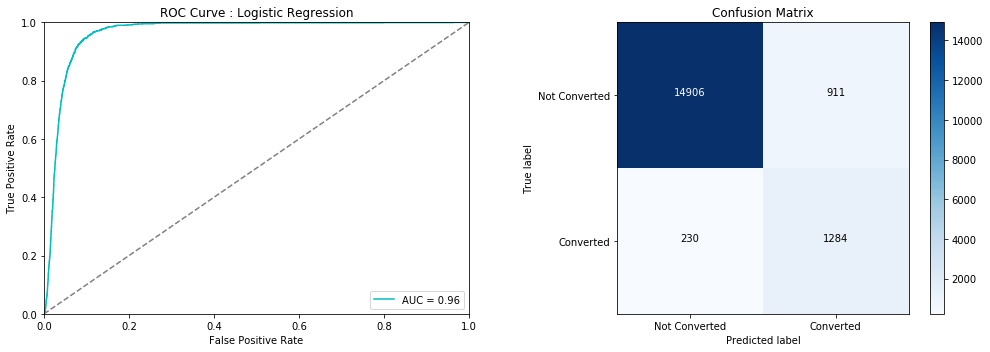

             precision    recall  f1-score   support

   visitors       0.98      0.94      0.96     15817
     Buyers       0.58      0.85      0.69      1514

avg / total       0.95      0.93      0.94     17331



In [75]:
# Create Logistic Regression Model
# We are using class_weight to be balanced so that weights are adjusted as per output class proportion
model = LogisticRegression(class_weight='balanced', random_state=99)
model_lr, fpr_lr, tpr_lr, auc_lr = Model_Report(model,'Logistic Regression', X_train, y_train, X_test, y_test)

# T-sne Plots

In [80]:
df_tsne=final_vec.sample(5000)

In [81]:
df_new = df_tsne.reset_index(drop=True)

In [82]:
df_new.shape

(5000, 100)

In [83]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=300)
tsne_results = tsne.fit_transform(df_new)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 2.891s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130774
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.168808
[t-SNE] Error after 300 iterations: 1.485842
t-SNE done! Time elapsed: 44.86812138557434 seconds


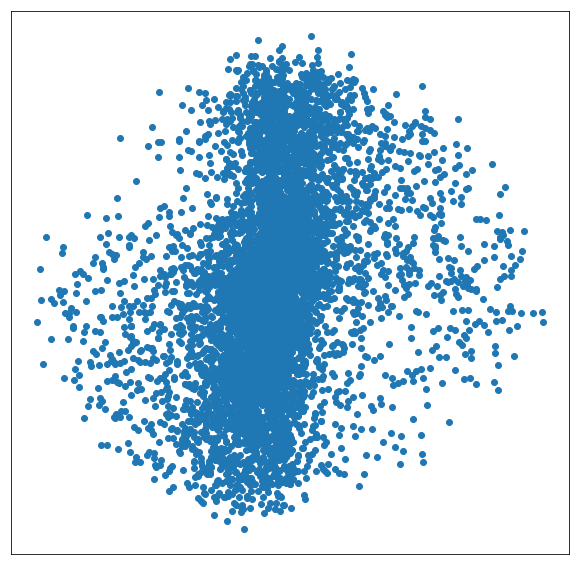

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [84]:
!pip install MulticoreTSNE

    100% |████████████████████████████████| 61kB 641kB/s 
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [85]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [90]:
tsne = TSNE(n_jobs=4,perplexity=20,n_iter=300)
Y = tsne.fit_transform(df_new)

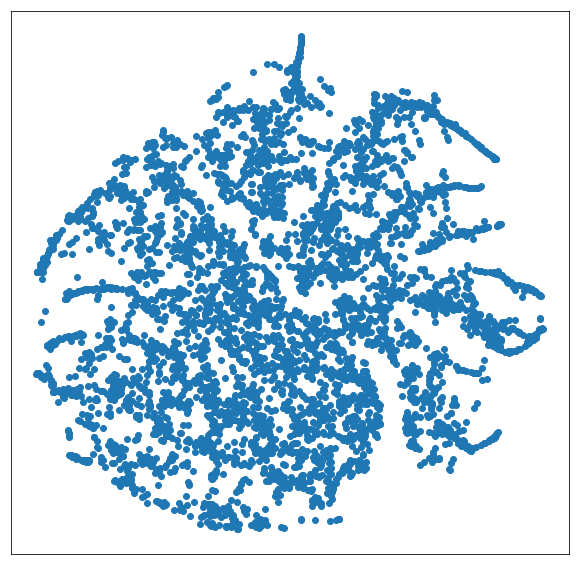

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.scatter(Y[:, 0], Y[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()